In [1]:
%matplotlib inline

import os, sys
sys.path.append(os.path.split(sys.path[0])[0])

from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from utils.plotting.plot_results import plot_LFP_traces,plot_LFP_heatmap
# from stylized_module.base.active_model_synapse_input import *
from stylized_module.base.passive_model_soma_injection import *
import config.params as params
import config.paths as paths

tstop = 20.  # ms
dt = 0.025  # ms. does not allow change

# h.nrn_load_dll(os.path.join(mechanisms_path,'nrnmech.dll'))  # running this line more than once might crash the kernel
# h.nrn_load_dll(os.path.join(mechanisms_path,'x86_64/.libs/libnrnmech.so'))  # use this line instead in Linux
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = tstop
h.dt = dt

In [2]:
#           [x, y, theta, h, phi] -> [80, 350, 3.0, 0.9, 1.27]
rng = np.random.default_rng(12345)
loc_param = [80,350,0.3,0.9,0.0]  # example position
#           [sr, trl,  trr, dr, tur, dl] -> [6.0, 400.0, 0.5, 0.5, 0.5, 200.0]
geo_param = [6.0,400.0,0.5,0.5,0.5,200.0]
loc_param_list = []
geo_param_list = []
ncell=6
for i in range(ncell):
    offset = i*0.5
    if offset > np.pi:
        offset = rng.uniform(low=0., high=np.pi)
    loc_param_list.append(loc_param[:4] + [(loc_param[4]+offset)])
#     loc_param_list.append(loc_param[:3]+[(loc_param[3]+offset)]+loc_param[4:])
    geo_param_list.append(geo_param)
    
# geo_param = [-1,-1,-1]  # choose trunk length [-1,600], bounds([3,12],[20,800],[0.2,1.0],[0.2,1.0],[0.2,1.0],[100,300])
# biophys = [-1,-1,-1,-1,-1]
loc_param = np.stack(loc_param_list)
geo_param = np.stack(geo_param_list)
np.set_printoptions(suppress=True)
print(loc_param)
print(geo_param)

[[ 80.  350.    0.3   0.9   0. ]
 [ 80.  350.    0.3   0.9   0.5]
 [ 80.  350.    0.3   0.9   1. ]
 [ 80.  350.    0.3   0.9   1.5]
 [ 80.  350.    0.3   0.9   2. ]
 [ 80.  350.    0.3   0.9   2.5]]
[[  6.  400.    0.5   0.5   0.5 200. ]
 [  6.  400.    0.5   0.5   0.5 200. ]
 [  6.  400.    0.5   0.5   0.5 200. ]
 [  6.  400.    0.5   0.5   0.5 200. ]
 [  6.  400.    0.5   0.5   0.5 200. ]
 [  6.  400.    0.5   0.5   0.5 200. ]]


In [3]:
hf = h5py.File(paths.INVIVO_DATA_FILE, 'r')
groundtruth_lfp = np.array(hf.get('data'))
hf.close()

maxIndx = np.argmax(np.absolute(groundtruth_lfp).max(axis=0))  # find maximum absolute value from averaged traces
maxTrace = -groundtruth_lfp[params.PM_START_IDX:,maxIndx]
soma_injection = np.insert(maxTrace,0,0.)
soma_injection = np.asarray([s * params.PM_SCALING_FACTOR for s in soma_injection])

# sim = Simulation(geo_standard,params.ELECTRODE_POSITION,loc_param,geo_param=geo_param,gmax=0.0025,scale=10000., ncell=ncell)  # gmax 0.001 -0.012
sim = Simulation(geo_standard,params.ELECTRODE_POSITION,soma_injection,loc_param=loc_param,geo_param=geo_param, ncell=ncell) 
sec_list = sim.cells[0].all
dend_v = Recorder([sec_list[5](0.1),sec_list[5](0.5),sec_list[5](0.9),sec_list[6](0.5)])

In [4]:
lfp_list = []
sim.run()
for i in range(ncell):
    lfp_list.append(sim.get_lfp(i).T)
    
t = sim.t()
print(np.stack(lfp_list, axis=-1).shape)

(801, 96, 6)


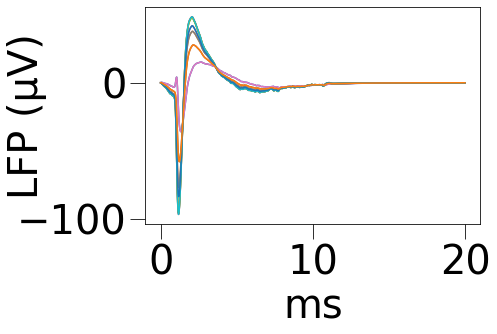

/home/matt/repos/Research/neurolab_file_transfer/utils/plotting/plot_results.py:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(t,elec_d,lfp,cmap=cmap,vmin=vlim[0],vmax=vlim[1],shading='auto')


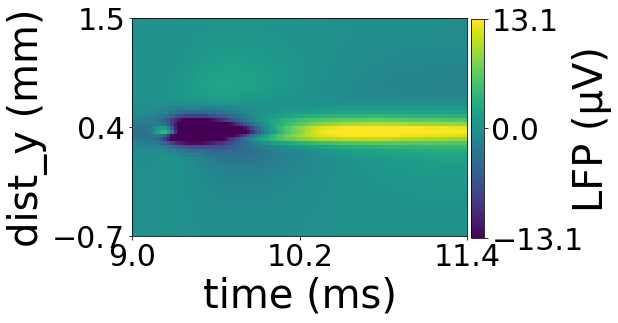

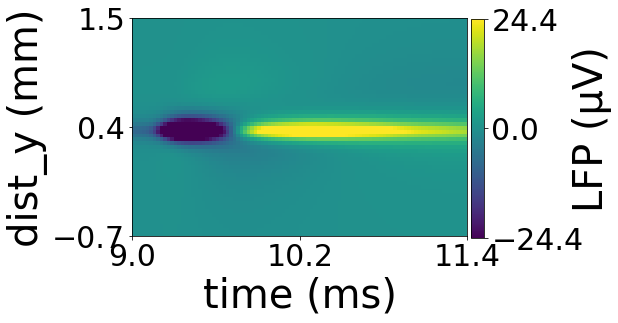

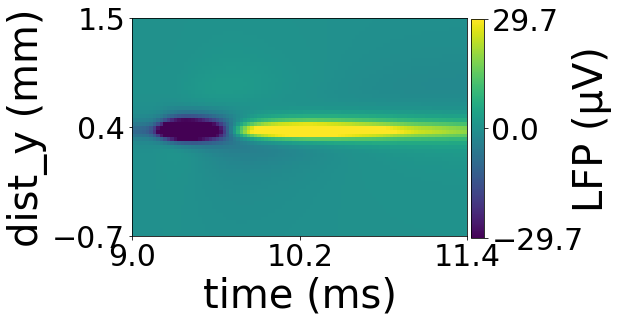

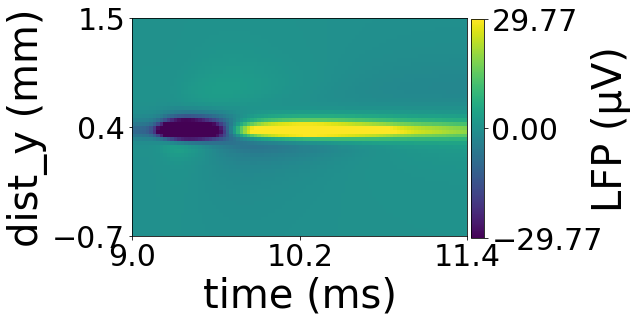

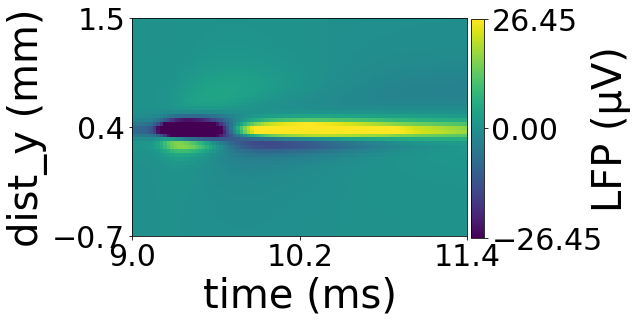

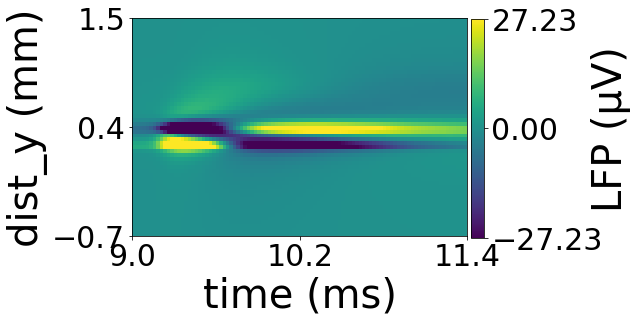

In [5]:
lfp_plot = np.stack(lfp_list, axis=-1)[:,56,:]
# argmax_list = []
# for i in range(lfp_plot.shape[0]):
#     argmax_list.append(np.argmax(lfp_plot[i,:,1]))
# print(argmax_list)

delay = 9.0
window = [delay,delay+2.51]
idx = (t>=window[0]) & (t<=window[1])  # time index
# print(t.shape)
fig,ax = plot_LFP_traces(t,lfp_plot,savefig=paths.IMAGE_SAVE + '/LFP_phi_traces.jpg')

from utils.spike_window import first_pk_tr, get_spike_window
# print(t[idx])

start,end = get_spike_window(lfp_list[0],win_size=params.PM_WINDOW_SIZE,align_at=20)
# predicted_lfp_win = ((lfp_list[0])[start:end,:])

elec_idx = slice(30,-10)
fig,ax = plot_LFP_heatmap(np.arange(9.,11.4,0.025),
                          params.IM_Y_DISTANCE[elec_idx],
                          ((lfp_list[0])[start:end,:])[:,elec_idx],
                          vlim='auto',
                          savefig=paths.IMAGE_SAVE + "/phi0_0_HM.jpg")
fig,ax = plot_LFP_heatmap(np.arange(9.,11.4,0.025),
                          params.IM_Y_DISTANCE[elec_idx],
                          ((lfp_list[1])[start:end,:])[:,elec_idx],
                          vlim='auto',
                          savefig=paths.IMAGE_SAVE + '/phi0_5_HM.jpg')
fig,ax = plot_LFP_heatmap(np.arange(9.,11.4,0.025),
                          params.IM_Y_DISTANCE[elec_idx],
                          ((lfp_list[2])[start:end,:])[:,elec_idx],
                          vlim='auto',
                          savefig=paths.IMAGE_SAVE + '/phi1_0_HM.jpg')
fig,ax = plot_LFP_heatmap(np.arange(9.,11.4,0.025),
                          params.IM_Y_DISTANCE[elec_idx],
                          ((lfp_list[3])[start:end,:])[:,elec_idx],
                          vlim='auto',
                          savefig=paths.IMAGE_SAVE + '/phi1_5_HM.jpg')
fig,ax = plot_LFP_heatmap(np.arange(9.,11.4,0.025),
                          params.IM_Y_DISTANCE[elec_idx],
                          ((lfp_list[4])[start:end,:])[:,elec_idx],
                          vlim='auto',
                          savefig=paths.IMAGE_SAVE + '/phi2_0_HM.jpg')
fig,ax = plot_LFP_heatmap(np.arange(9.,11.4,0.025),
                          params.IM_Y_DISTANCE[elec_idx],
                          ((lfp_list[5])[start:end,:])[:,elec_idx],
                          vlim='auto',
                          savefig=paths.IMAGE_SAVE + '/phi2_5_HM.jpg')

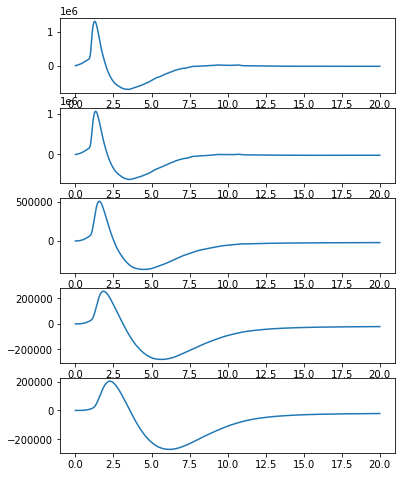

In [6]:
v_dend = dend_v.as_numpy()
plt.figure(figsize=(6,8))
plt.subplot(5,1,1)
plt.plot(t,sim.cells[0].v())
for i in range(v_dend.shape[0]):
    plt.subplot(5,1,i+2)
    plt.plot(t,v_dend[i,:])
plt.show()

In [7]:
filt_b,filt_a = signal.butter(2,100,'hp',fs=40000) # order 2, 100 Hz, highpass, sampling rate = 40kHz
lfp = signal.lfilter(filt_b,filt_a,lfp,axis=0)
print(lfp.shape)

NameError: name 'lfp' is not defined

In [ ]:
delay = 9.0
window = [delay,delay+2.51]
idx = (t>=window[0]) & (t<=window[1])  # time index
fig,ax = plot_LFP_traces(t[idx],lfp[idx,:])

In [ ]:
e_idx = slice(40,-20)  # electrodes index
fig,ax = plot_LFP_heatmap(t[idx],pos[e_idx,1],lfp[idx,e_idx])
# set narrower "vlim" can help see more subtle difference in voltage

Below is an example to find the spike waveform window. First import the functions and obtain the index of first peak/trough of the ground truth trace in the given window.

In [ ]:
from utils.spike_window import first_pk_tr, get_spike_window

fst_idx = first_pk_tr(lfp[idx,:])
print("index %d, time %f" % (fst_idx,fst_idx*dt)) # in this case, trough occurs earlier than peak. so the trough index is ruterned

Run a simulate with lower input (gmax). In such case, the first peak/trough occurs later.

In [ ]:
sim = Simulation(geo_standard,params.ELECTRODE_POSITION,loc_param,gmax=0.002,scale=10000.)
sim.run()
lfp = sim.get_lfp().T
t = sim.t()

In [ ]:
plt.plot(t,sim.cells[0].v())
plt.show()

Use the function "get_spike_window" to get the window of the waveform with 96 time points, using the "fst_idx" point in the given window of the ground truth trace to align with the first peak/trough of this simulated trace. Plot the waveform in the window obtained.

In [ ]:
start,end = get_spike_window(lfp,win_size=96,align_at=fst_idx)
fig,ax = plot_LFP_traces(t[start:end],lfp[start:end,:])

In [ ]:
help(first_pk_tr)
help(get_spike_window)